# Fine-tuning Bert with PrivacyQA

In this experiment, we download, tokenize, and train a 🤗 Transformers model on the PrivacyQA question/answering data. This task takes the text of a privacy-related question asked by a user and requires the model to predict whether the sentiment of the review is positive or negative.

# Imports / Dependencies

In [ ]:
# Transformers installation
! pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

     |████████████████████████████████| 2.3MB 7.5MB/s 
     |████████████████████████████████| 3.3MB 50.0MB/s 
     |████████████████████████████████| 901kB 46.7MB/s 


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import transformers
from transformers import DistilBertTokenizerFast, DistilBertModel, BertConfig, DistilBertPreTrainedModel
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score
import pickle

# Prepare the Data

Mount google drive

In [ ]:
!rm -rf ./sample_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Read in the PrivacyQA dataset from google drive (assuming you have a shortcut to the 'privacyQA_dataset' directory under 'MyDrive')

In [ ]:
train_set = pd.read_csv('/content/drive/MyDrive/828E_Ophir_Mollie/privacyQA_dataset/train_opp_annotations')
test_set = pd.read_csv('/content/drive/MyDrive/828E_Ophir_Mollie/privacyQA_dataset/test_opp_annotations')
print(train_set.head())
print(test_set.head())

                                 Folder  ... other
0  ../../Dataset/Train/com.cake.browser  ...     0
1  ../../Dataset/Train/com.cake.browser  ...     0
2  ../../Dataset/Train/com.cake.browser  ...     0
3  ../../Dataset/Train/com.cake.browser  ...     0
4  ../../Dataset/Train/com.cake.browser  ...     0

[5 rows x 12 columns]
                                 Folder      DocID  ... audiences unknown
0  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0
1  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0
2  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0
3  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0
4  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0

[5 rows x 14 columns]


Drop the unnecessary columns ('audiences' and 'unknown') from the test set.

In [ ]:
test_set = test_set.drop(['audiences', 'unknown'], axis=1)
print(test_set.head())

                                 Folder      DocID  ... user_choice other
0  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0
1  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0
2  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0
3  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0
4  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0

[5 rows x 12 columns]


Now let's create sets of inputs (query texts) and labels (onehot-encoded) out of the train and test sets.

In [ ]:
def read_pqa_split(dataset):
    """ assumes `dataset` is a pandas DataFrame """
    texts = dataset.Query.to_list()
    label_cols = dataset.columns[5:]
    labels = dataset[label_cols].values.tolist() # onehot-encoded labels
    return texts, labels

train_texts, train_labels = read_pqa_split(train_set)
test_texts, test_labels = read_pqa_split(test_set)

Let's check the class distribution in the training set 

In [ ]:
np.array(train_labels).sum(axis=0)

array([619, 323, 153,  85,  31,  88,  20])

We now have a train and test dataset, but let's also also create a validation set which we can use for for evaluation
and tuning without tainting our test set results. Sklearn has a convenient utility for creating such splits:

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2, random_state=42)

Alright, we've read in our dataset. Now let's tackle tokenization. We'll eventually train a classifier using
pre-trained DistilBert, so let's use the DistilBert tokenizer.

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('bert-base-uncased')

Now we can simply pass our texts to the tokenizer. We'll pass `truncation=True` and `padding=True`, which will
ensure that all of our sequences are padded to the same length and are truncated to be no longer model's maximum input
length. This will allow us to feed batches of sequences into the model at the same time.

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Now, let's turn our labels and encodings into a Dataset object. In PyTorch, this is done by subclassing a
`torch.utils.data.Dataset` object and implementing `__len__` and `__getitem__`. In TensorFlow, we pass our input
encodings and labels to the `from_tensor_slices` constructor method. We put the data in this format so that the data
can be easily batched such that each key in the batch encoding corresponds to a named parameter of the
`DistilBertForSequenceClassification.forward` method of the model we will train.

In [ ]:
class PqaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PqaDataset(train_encodings, train_labels)
val_dataset = PqaDataset(val_encodings, val_labels)
test_dataset = PqaDataset(test_encodings, test_labels)

Now that our datasets our ready, we can fine-tune a model either with the 🤗
`Trainer`/`TFTrainer` or with native PyTorch/TensorFlow. See [training](https://huggingface.co/transformers/training.html).

# Fine-tuning with the `Trainer` module

The steps above prepared the datasets in the way that the trainer is expecting. Now all we need to do is create a model
to fine-tune, define the `TrainingArguments`/`TFTrainingArguments` and
instantiate a `Trainer`/`TFTrainer`.

Importantly, we need to subclass the Trainer class to make it suitable for multilabel classification (by default it is suited for **_multiclass_** classification, which is different and not waht we want here). The extended class was taken from the example at https://huggingface.co/transformers/main_classes/trainer.html#codecell0.

First, we need to subclass and adapt the original DistilBert for multi-label calssification --

In [ ]:
class DistilBertForMultilabelSequenceClassification(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.distilbert = DistilBertModel(config)
        self.pre_classifier = torch.nn.Linear(config.dim, config.dim)
        self.classifier = torch.nn.Linear(config.dim, config.num_labels)
        self.dropout = torch.nn.Dropout(config.seq_classif_dropout)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = torch.nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, num_labels)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                # the onlny modification to the original DistilBert is below
                loss_fct = torch.nn.BCEWithLogitsLoss()
                loss = loss_fct(logits.view(-1, self.distilbert.config.num_labels),
                                labels.float().view(-1, self.distilbert.config.num_labels))

        if not return_dict:
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return transformers.modeling_outputs.SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )

Define directory to save model and other files --

In [ ]:
model_dir = '/content/drive/MyDrive/828E_Ophir_Mollie/trained_models/non-robust_model_300_epochs'

Then, we can instantiate the model and train it --- 

In [ ]:
label_names = ['first', 'third', 'datasecurity', 'dataretention', 'user_access', 'user_choice', 'other']

training_args = TrainingArguments(
    output_dir=model_dir, # output directory for model predictions and checkpoints
    num_train_epochs=300,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_steps=10,
    logging_dir=model_dir,
    load_best_model_at_end=True, # will save/checkpoint the model after every evaluation
    evaluation_strategy="epoch", # will evaluate every epoch
    # DO NOT USE # label_names=label_names,  # DO NOT USE THIS --- THROWS ERROR
)

NUM_LABELS = len(label_names)
model = DistilBertForMultilabelSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=NUM_LABELS,
    id2label=dict(enumerate(label_names)), # use to show text labels
    )

# Customized Trainer class for Multi-label classification
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

trainer = MultilabelTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
)

# Start the training
trainer.train()
# Save model
model.save_pretrained(model_dir)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForMultilabelSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForMultilabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForMultilabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForMultilabelSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier

Epoch,Training Loss,Validation Loss
1,0.554600,0.476814
2,0.358200,0.335507
3,0.300400,0.280663
4,0.252100,0.240909
5,0.202100,0.207750
6,0.157900,0.190076
7,0.138000,0.205722
8,0.146900,0.200561
9,0.073900,0.209807
10,0.076000,0.237485


# Plotting Training history

In [ ]:
log = """Epoch	Training Loss	Validation Loss
1	0.554600	0.476814
2	0.358200	0.335507
3	0.300400	0.280663
4	0.252100	0.240909
5	0.202100	0.207750
6	0.157900	0.190076
7	0.138000	0.205722
8	0.146900	0.200561
9	0.073900	0.209807
10	0.076000	0.237485
11	0.084400	0.227196
12	0.070400	0.234334
13	0.065100	0.274569
14	0.053000	0.246515
15	0.055900	0.287372
16	0.034000	0.327091
17	0.039300	0.324837
18	0.058300	0.348900
19	0.042500	0.324001
20	0.043200	0.325551
21	0.034000	0.367903
22	0.026300	0.356268
23	0.033000	0.354767
24	0.027400	0.347020
25	0.030600	0.340876
26	0.026500	0.373124
27	0.021900	0.358033
28	0.027600	0.369370
29	0.031100	0.389386
30	0.023200	0.383874
31	0.024000	0.384754
32	0.028100	0.377766
33	0.023700	0.401635
34	0.023300	0.390374
35	0.024500	0.387348
36	0.021600	0.415785
37	0.021200	0.417831
38	0.019900	0.425398
39	0.024700	0.432167
40	0.025100	0.415257
41	0.013600	0.418001
42	0.021600	0.425339
43	0.020400	0.438871
44	0.013900	0.442983
45	0.019100	0.456746
46	0.027200	0.442537
47	0.032900	0.516292
48	0.023300	0.439773
49	0.027100	0.451739
50	0.013300	0.476499
51	0.019300	0.479299
52	0.027600	0.482413
53	0.014800	0.489457
54	0.016200	0.474238
55	0.012200	0.472639
56	0.024200	0.470911
57	0.016500	0.435930
58	0.013000	0.481936
59	0.027700	0.419252
60	0.026400	0.493274
61	0.028600	0.515932
62	0.022500	0.500374
63	0.033400	0.445355
64	0.019700	0.484931
65	0.027100	0.482232
66	0.020000	0.498137
67	0.020400	0.460240
68	0.025600	0.515070
69	0.023800	0.516372
70	0.029700	0.488822
71	0.028600	0.527307
72	0.027400	0.515819
73	0.010500	0.524639
74	0.021500	0.541938
75	0.019700	0.524445
76	0.023000	0.541470
77	0.015500	0.529235
78	0.014300	0.543262
79	0.022500	0.537436
80	0.019000	0.547688
81	0.015200	0.555483
82	0.019200	0.540467
83	0.019800	0.551950
84	0.026300	0.544304
85	0.029600	0.554489
86	0.016600	0.562538
87	0.022700	0.553076
88	0.014300	0.540543
89	0.024400	0.559860
90	0.014500	0.549182
91	0.019000	0.558275
92	0.022500	0.498479
93	0.041500	0.610871
94	0.039200	0.527485
95	0.034600	0.571551
96	0.026200	0.560353
97	0.020100	0.550000
98	0.024700	0.525870
99	0.018900	0.567397
100	0.018000	0.582305
101	0.021000	0.593353
102	0.019900	0.568779
103	0.033300	0.557487
104	0.014800	0.569213
105	0.014800	0.588160
106	0.019800	0.575727
107	0.024600	0.599797
108	0.014900	0.669690
109	0.027500	0.606357
110	0.024600	0.635701
111	0.023900	0.615369
112	0.012700	0.603370
113	0.012600	0.608340
114	0.023500	0.612880
115	0.014200	0.608424
116	0.019800	0.615510
117	0.018900	0.623908
118	0.025400	0.606558
119	0.024300	0.635232
120	0.019200	0.621012
121	0.013700	0.618489
122	0.016000	0.622519
123	0.016100	0.620339
124	0.021800	0.623292
125	0.018800	0.626908
126	0.012300	0.632213
127	0.024000	0.639376
128	0.017500	0.640542
129	0.024000	0.644039
130	0.015200	0.643004
131	0.015700	0.646033
132	0.022600	0.641046
133	0.029100	0.637487
134	0.022700	0.641872
135	0.016200	0.640165
136	0.008700	0.646294
137	0.013500	0.644724
138	0.016200	0.644125
139	0.010700	0.642327
140	0.021700	0.646487
141	0.019000	0.673653
142	0.012200	0.590285
143	0.016500	0.612552
144	0.013600	0.634569
145	0.014800	0.668577
146	0.012500	0.628731
147	0.020300	0.620603
148	0.017400	0.660750
149	0.019100	0.600622
150	0.020900	0.646772
151	0.043400	0.588524
152	0.014400	0.566710
153	0.011900	0.592999
154	0.013500	0.605294
155	0.015900	0.606451
156	0.012100	0.612743
157	0.026600	0.615602
158	0.016900	0.609241
159	0.015600	0.615288
160	0.018800	0.622206
161	0.021800	0.632497
162	0.017900	0.631570
163	0.020900	0.626640
164	0.013200	0.634929
165	0.017200	0.638805
166	0.019000	0.636170
167	0.021300	0.631273
168	0.019500	0.633644
169	0.021600	0.637526
170	0.015000	0.641151
171	0.012600	0.643073
172	0.020400	0.645353
173	0.022300	0.639072
174	0.018000	0.638927
175	0.018200	0.643871
176	0.017300	0.648241
177	0.013700	0.648809
178	0.018700	0.647216
179	0.015400	0.650886
180	0.018700	0.647149
181	0.021100	0.645277
182	0.022500	0.653685
183	0.016700	0.650286
184	0.016000	0.652955
185	0.021300	0.660605
186	0.018600	0.660991
187	0.013900	0.664113
188	0.025300	0.661687
189	0.021900	0.664076
190	0.017500	0.657430
191	0.011200	0.659126
192	0.017500	0.663684
193	0.015500	0.662848
194	0.020700	0.700385
195	0.016400	0.676004
196	0.019600	0.639332
197	0.013600	0.701483
198	0.022500	0.687136
199	0.020700	0.681243
200	0.019500	0.676304
201	0.013000	0.676389
202	0.022300	0.681180
203	0.014700	0.683540
204	0.028600	0.692805
205	0.014000	0.686234
206	0.016600	0.682270
207	0.020000	0.680287
208	0.013000	0.679630
209	0.016300	0.679345
210	0.015600	0.677968
211	0.012200	0.683729
212	0.025700	0.686493
213	0.016900	0.683703
214	0.025700	0.684375
215	0.024100	0.699602
216	0.016900	0.693107
217	0.017600	0.695089
218	0.016900	0.694003
219	0.017500	0.696781
220	0.013700	0.695675
221	0.020400	0.695107
222	0.015800	0.696925
223	0.017300	0.694317
224	0.019900	0.666868
225	0.014200	0.658070
226	0.025300	0.682873
227	0.018000	0.656140
228	0.019800	0.667195
229	0.017700	0.676459
230	0.015300	0.672211
231	0.016800	0.671186
232	0.022100	0.674170
233	0.018500	0.674562
234	0.013600	0.671166
235	0.016900	0.672435
236	0.020200	0.675842
237	0.022800	0.673142
238	0.020900	0.678629
239	0.016000	0.682159
240	0.026800	0.679606
241	0.018000	0.679899
242	0.018500	0.682495
243	0.019400	0.680135
244	0.018400	0.678236
245	0.015400	0.680157
246	0.019900	0.682417
247	0.021100	0.691712
248	0.015000	0.689158
249	0.021100	0.692350
250	0.019300	0.696499
251	0.020700	0.694929
252	0.016800	0.695546
253	0.017300	0.696196
254	0.025400	0.694413
255	0.018000	0.691341
256	0.014300	0.689876
257	0.017700	0.688994
258	0.016000	0.689558
259	0.008200	0.692603
260	0.020800	0.694721
261	0.017800	0.711811
262	0.018400	0.712433
263	0.013100	0.708343
264	0.008700	0.706530
265	0.010800	0.706288
266	0.015500	0.704641
267	0.016600	0.703486
268	0.019100	0.707051
269	0.017600	0.707128
270	0.012800	0.704545
271	0.024600	0.706110
272	0.014700	0.708134
273	0.014100	0.708087
274	0.023500	0.706224
275	0.014500	0.709496
276	0.016400	0.706398
277	0.015200	0.705772
278	0.018700	0.704297
279	0.022400	0.698047
280	0.017600	0.703189
281	0.020000	0.701482
282	0.016300	0.702580
283	0.017300	0.703592
284	0.017700	0.703503
285	0.008200	0.704292
286	0.016400	0.705641
287	0.020900	0.706207
288	0.013300	0.704737
289	0.019100	0.705650
290	0.014600	0.706362
291	0.012700	0.706809
292	0.021300	0.707692
293	0.011700	0.708210
294	0.011800	0.708723
295	0.020200	0.708964
296	0.022700	0.709000
297	0.018000	0.709469
298	0.022500	0.710030
299	0.023400	0.710042
300	0.011900	0.710049
"""
with open(model_dir+'/train_history_log', 'w') as f:
    f.write(log)

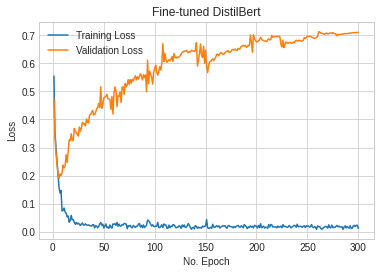

In [ ]:
history = pd.read_csv(model_dir+'/train_history_log',sep='\t')

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(6,4))
plt.plot(history['Epoch'], history['Training Loss'], label='Training Loss')
plt.plot(history['Epoch'], history['Validation Loss'], label='Validation Loss')
plt.xlabel("No. Epoch")
plt.ylabel("Loss")
plt.title("Fine-tuned DistilBert")
plt.legend()
plt.savefig(model_dir+'/train_history_plot.png', dpi=300)
plt.show()

# Evaluation

Let's load up the trained model (if not already loaded)

In [ ]:
label_names = ['first', 'third', 'datasecurity', 'dataretention',
                           'user_access', 'user_choice', 'other']
NUM_LABELS = len(label_names)
# Loading the checkpoint with the best validation loss (checkpoint-408)
path_to_model_dir = model_dir
model = DistilBertForMultilabelSequenceClassification.from_pretrained(
    path_to_model_dir, 
    num_labels=NUM_LABELS,
    id2label=dict(enumerate(label_names)), # use to show text labels
)

Set it to evaluation mode --

In [ ]:
model.eval()
model.to('cpu')

DistilBertForMultilabelSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=Fals

## Qualitative Evaluation (Simple Predictions for Text Queries)

In [ ]:
# Convert token to vocabulary indices
some_queries = ["what information do you collect?",  # label: 'first'
                "are you certified to be secure?",   # label: 'datasecurity'
                "who can read the chat i have with the platform?",   # labels: ['first',	'third']
                ]

def predict_labels(model, query):
    labels = np.array(['first', 'third', 'datasecurity', 'dataretention',
                           'user_access', 'user_choice', 'other'])
    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor(tokenizer([query], truncation=True, padding=True)['input_ids'])
    model.eval()
    tokens_tensor.to('cpu')
    model.to('cpu')
    probabilities = torch.sigmoid(model(tokens_tensor)[0][0])
    bool_pred = np.array([True if p > 0.5 else False for p in probabilities])
    label_pred = labels[bool_pred].tolist()
    return label_pred

for query in some_queries:
    print(predict_labels(model, query))

['first']
['datasecurity']
['first']


Let's check for consistency/robustness --

In [ ]:
print(predict_labels(model, "will other companies have access to my info?"))
print(predict_labels(model, "will other companies have access to my information?"))
print(predict_labels(model, "will other companies have access to my information?"))
print(predict_labels(model, "will other entities see my data?"))
print(predict_labels(model, "will other entities see my info?"))
print(predict_labels(model, "will other companies see my data?"))
print()
print(predict_labels(model, "will you allow me to remove data?"))
print(predict_labels(model, "will you let me to remove stuff?"))
print(predict_labels(model, "will you let me to remove everything?"))
print()
print(predict_labels(model, "could I delete my data?"))
print(predict_labels(model, "will I be able to delete my information?"))
print()
print(predict_labels(model, "will you keep my information forever?"))
print(predict_labels(model, "What will you do to my information?"))
print(predict_labels(model, "What will you do to my data?"))

['first', 'third']
['third']
['third']
['third']
['first', 'third']
['third']

[]
[]
[]

['user_access']
['user_access']

['dataretention']
['first']
['first']


We can see that small changes to the input will sometimes affect the model's output. We wanna see if we can make the model more robust to these changes by adding adversarial examples to the data.

## Quantitative Evaluation

Let's do a quick check to see that the model is indeed the one that performed best on the validation set (i.e. a loss of ~0.2) --

In [ ]:
evaluator = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=val_dataset,             # evaluation dataset
)

eval_results = evaluator.evaluate()
print()
for key in ['eval_loss']:
    value = eval_results[key]
    if type(value) != type(np.array([])):
        print(f'{key}:', value)
    else:
        print(f'{key}:\n')
        for lab, val in zip(label_names, value): 
            print(f'{lab}:', val)
    print()


eval_loss: 0.19007571041584015



Get the predictions and ground truths --

In [ ]:
model.to('cpu')

DistilBertForMultilabelSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
# Plot normalized confusion matrix (values in [0,1])
def predict_one_hot(model, input_tokens, thresh=0.5):
    # Convert inputs to PyTorch tensors
    model.to('cpu')
    probabilities = torch.sigmoid(model(input_tokens)[0][0])
    one_hot_pred = np.array([1 if p > thresh else 0 for p in probabilities])
    return one_hot_pred

# produce one-hot preds 
y_true = val_dataset[:]['labels'].tolist()
y_pred = torch.sigmoid(model(val_dataset[:]['input_ids'])[0]).round().detach().numpy().astype('int32').tolist()

## Confusion Matrix

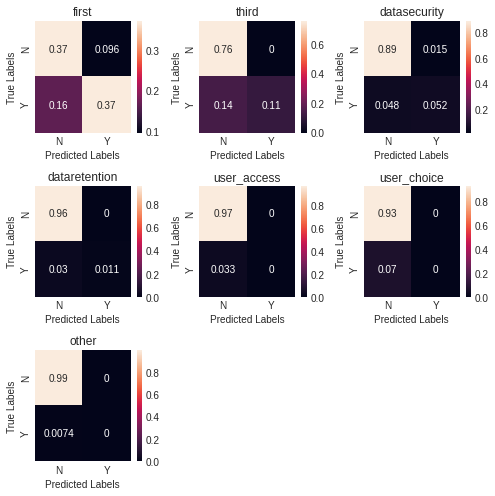

In [ ]:
label_names = ['first', 'third', 'datasecurity', 'dataretention',
                           'user_access', 'user_choice', 'other']
con_mat = multilabel_confusion_matrix(y_true, y_pred) / len(y_true)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7,7))
for i, ax in enumerate(axes.flat):
    if i < 7:
        con_mat_df = pd.DataFrame(con_mat[i], index=['N', 'Y'], columns=['N', 'Y'])    
        sns.heatmap(con_mat_df, annot=True, ax=ax)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title(label_names[i])
    else:
        ax.set_visible(False)

plt.tight_layout() 
plt.savefig(model_dir+'/confusion_matrices.png', dpi=300)
plt.show()

## Evaluate the model with the following metrics: accuracy, F1 score, precision, and recall.

In [ ]:
label_names = ['first', 'third', 'datasecurity', 'dataretention', 'user_access', 'user_choice', 'other']
# Print and save classification report
print('Validation F1 Accuracy: ', f1_score(y_true, y_pred,average='micro'))
print('Validation Flat Accuracy: ', accuracy_score(y_true, y_pred),'\n')
clf_report = classification_report(y_true, y_pred, target_names=label_names)
pickle.dump(clf_report, open(model_dir+'/classification_report.txt','wb')) #save report
print(clf_report)

Validation F1 Accuracy:  0.6431718061674009
Validation Flat Accuracy:  0.5222222222222223 

               precision    recall  f1-score   support

        first       0.79      0.69      0.74       144
        third       1.00      0.44      0.61        66
 datasecurity       0.78      0.52      0.62        27
dataretention       1.00      0.27      0.43        11
  user_access       0.00      0.00      0.00         9
  user_choice       0.00      0.00      0.00        19
        other       0.00      0.00      0.00         2

    micro avg       0.83      0.53      0.64       278
    macro avg       0.51      0.28      0.34       278
 weighted avg       0.76      0.53      0.61       278
  samples avg       0.53      0.49      0.50       278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
